In [1]:
!python ../setup.py build_ext --inplace

running build_ext
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include/python2.7 -c /tmp/tmp24IrPa.cpp -o tmp/tmp24IrPa.o -std=c++14
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include/python2.7 -c /tmp/tmpexmnz4.cpp -o tmp/tmpexmnz4.o -fvisibility=hidden
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
building 'coresets.sensitivity' extension
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include -I/root/anaconda3/envs/py2/include -I/r

In [2]:
!python --version

Python 2.7.17 :: Anaconda, Inc.


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
np.random.seed(42)
#from utils import datagen, plotting
#import coresets
#import algorithms
import csv
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, scale
from math import sqrt,log
import pandas as pd
import tensorflow as tf
import timeit 

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
#import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

# Importing the required Keras modules containing model and layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [5]:
##few func defintions
#normalize pdf area to 1:
def normaliz(array):
    normalized = []
    s=sum(array)
    for i in range(len(array)):
        n=array[i]/s
        normalized.append(n)
    return normalized
#Calculate mean
def mean(array):
    return sum(array)/float(len(array))
 
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)
#kl divergence
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    c = 0
    for i in range(len(p)):
        if(p[i]!=0) and (q[i]!=0):
        #if(p[i]!=0):
            c=c+p[i]*log(p[i]/q[i])     
    return c
    #return np.sum(np.where(p != 0 , p * np.log(p / q), 0))
    
def dist(x,y):   
    return sqrt(np.sum((x-y)**2))

def cost(data,clusters):
    k=len(clusters)
    min_dist = []
    for i in range(len(data)):
        d = []
        for j in range(k):
            d.append(dist(data[i],clusters[j]))
        min_dist.append(np.min(d))
    cost = sum(min_dist)
    return cost
#kl divergence
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    c = 0
    for i in range(len(p)):
        if(p[i]!=0) and (q[i]!=0):
        #if(p[i]!=0):
            c=c+p[i]*log(p[i]/q[i])     
    return c
    #return np.sum(np.where(p != 0 , p * np.log(p / q), 0))
    

In [6]:
#window kernel
def window_function(x_vec, unit_len=1):
    for row in x_vec:
        if np.abs(row) > (unit_len/2):
            return 0
    return 1

def kernel_func(h, x, x_i):
    assert (x.shape == x_i.shape), 'vectors x and x_i must have the same dimensions'
    return (x - x_i) / h

def window_func(x_vec, h):
   
    for row in x_vec:
        if np.abs(row) > 0.5:
            #print(row)
            return 0
    return 1
    #dist=sqrt(np.sum((x_vec)**2))
    #print("distance="+str(dist))
    #if dist > 0.5:
     #   return 0
    #else: 
     #   return 1

#main parzen window function
def parzen_estimate(x_samples, point_x, h, d):
    
    k_n = 0
    for row in x_samples:
        x_i = kernel_func(h=h, x=point_x, x_i=row[:,np.newaxis])
        #x_i = kernel_func(h=h, x=point_x, x_i=row)
        k_n += window_func(x_i, h=h)
        
    #print(k_n)
    temp1=float(k_n)/(h**d)
    temp2=temp1/len(x_samples)
    return temp2
    #return (float(k_n) / len(x_samples)) / (h**d)
    
def covar(data):
    mean_data=data.mean(axis=0)   
    cov=np.zeros((len(mean_data),len(mean_data)))
    for i in range(len(mean_data)):
        for j in range(len(mean_data)):
            for k in range(len(data)):
                cov[i][j]=cov[i][j]+((data[k][i]-mean_data[i])*(data[k][j]-mean_data[j]))
            cov[i][j]=cov[i][j]/(len(data)-1)
    return cov  

def show_img(data,idx):
    data *= 255
    im=np.reshape(data[idx],(28,28))
    plt.imshow(im,cmap='Greys')

In [7]:
#import MNIST train set
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_df=pd.read_csv('mnist_train.csv', sep=',')

#convert df to np
x_train_temp_np=x_train_df.to_numpy()

#dividing into labels and data 
x_train_data=x_train_temp_np[:, 1:785]
x_train_label=x_train_temp_np[:,[0]]


In [8]:
#import MNIST test set
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test_df=pd.read_csv('mnist_test.csv', sep=',')

#convert df to np
x_test_temp_np=x_test_df.to_numpy()

#dividing into labels and data 
x_test_data=x_test_temp_np[:, 1:785]
x_test_label=x_test_temp_np[:,[0]]



In [9]:
#normalizing both train and test data with max RGB value
x_train_data_norm=x_train_data.astype('float')
x_test_data_norm=x_test_data.astype('float')
x_train_data_norm/=255
x_test_data_norm/=255
data_length=20000
b=int(sqrt(data_length))
print(b)

141


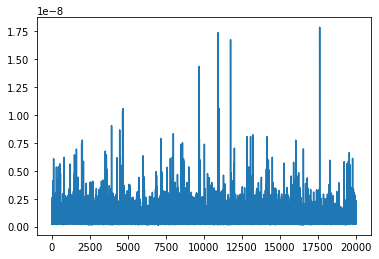

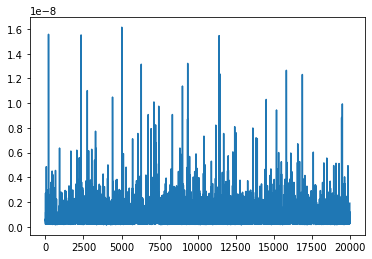

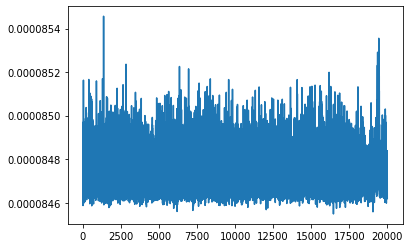

In [10]:
df=pd.read_csv('MNIST_KL20.csv')#load 20K
kl_load20=df.to_numpy()
plt.plot(kl_load20)
plt.show()
df=pd.read_csv('MNIST_KL2040.csv')#load 20Kto40k
kl_load2040=df.to_numpy()
plt.plot(kl_load2040)
plt.show()
df=pd.read_csv('MNIST_KL4060.csv')#load 40Kto60k
kl_load4060=df.to_numpy()
plt.plot(kl_load4060)
plt.show()



In [11]:
#convert training record to 2D for DL feeding

x_train_data_2D = []
print(len(x_train_data_norm[0:60000]))
for i in range(len(x_train_data_norm[0:60000])):
    #x_test_data_norm[i] *= 255
    sqr_test=np.reshape(x_train_data_norm[i],(28,28))
    x_train_data_2D.append(sqr_test)

x_train_data_2D_np=np.array(x_train_data_2D)

#preprocessing for Keras
x_data_2D_train = x_train_data_2D_np.reshape(x_train_data_2D_np.shape[0], 28, 28, 1)
x_train_data_2D_np.shape

60000


(60000, 28, 28)

In [12]:
#convert test record to 2D for DL feeding
x_test_data_2D = []
print(len(x_test_data_norm))
for i in range(len(x_test_data_norm)):
    #x_test_data_norm[i] *= 255
    sqr_test=np.reshape(x_test_data_norm[i],(28,28))
    x_test_data_2D.append(sqr_test)

x_test_data_2D_np=np.array(x_test_data_2D)

#preprocessing for Keras
x_data_2D_test = x_test_data_2D_np.reshape(x_test_data_2D_np.shape[0], 28, 28, 1)
x_test_data_2D_np.shape

10000


(10000, 28, 28)

In [16]:
#CNN on full set

# Creating a Sequential Model and adding the layers
input_shape = (28, 28, 1)
fullset_model = Sequential()
fullset_model.add(Conv2D(28, kernel_size=(4,4), input_shape=input_shape))
fullset_model.add(MaxPooling2D(pool_size=(2, 2)))
fullset_model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
fullset_model.add(Dense(128, activation=tf.nn.relu))
fullset_model.add(Dropout(0.2))
fullset_model.add(Dense(10,activation=tf.nn.softmax))

fullset_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fullset_model.fit(x=x_data_2D_train,y=x_train_label[0:60000], epochs=10)

Epoch 1/10
60000/60000 [==============================] - 12s 207us/sample - loss: 0.2009 - acc: 0.9397
Epoch 2/10
60000/60000 [==============================] - 15s 242us/sample - loss: 0.0826 - acc: 0.9754
Epoch 3/10
60000/60000 [==============================] - 16s 266us/sample - loss: 0.0598 - acc: 0.9812
Epoch 4/10
60000/60000 [==============================] - 17s 276us/sample - loss: 0.0471 - acc: 0.9846
Epoch 5/10
60000/60000 [==============================] - 18s 292us/sample - loss: 0.0355 - acc: 0.9887
Epoch 6/10
60000/60000 [==============================] - 18s 300us/sample - loss: 0.0331 - acc: 0.9891
Epoch 7/10
60000/60000 [==============================] - 18s 303us/sample - loss: 0.0270 - acc: 0.9909
Epoch 8/10
60000/60000 [==============================] - 18s 297us/sample - loss: 0.0231 - acc: 0.9923
Epoch 9/10
60000/60000 [==============================] - 18s 299us/sample - loss: 0.0222 - acc: 0.9922
Epoch 10/10
60000/60000 [==============================] - 17s 2

In [17]:
fullset_model.evaluate(x_data_2D_test,x_test_label)

10000/10000 [==============================] - 1s 82us/sample - loss: 0.0661 - acc: 0.9851


[0.0660994412937986, 0.9851]

In [18]:
#coreset procedure begins
#appending the KL records
temp=np.vstack((kl_load20,kl_load2040))
kl_load_full=np.vstack((temp,kl_load4060))
#append label and KL weight and sort
x_data_label_merge=np.column_stack((x_train_data_norm[0:60000],x_train_label[0:60000]))
x_data_label_kl_merge=np.column_stack((x_data_label_merge,kl_load_full))
print(x_data_label_kl_merge[:,785])
x_data_label_kl_merge_sort=x_data_label_kl_merge[x_data_label_kl_merge[:,785].argsort()]

[3.28999033e-10 4.79440155e-10 6.26730418e-10 ... 8.47246133e-05
 8.46396184e-05 8.46192863e-05]


Following digit to be recognized:


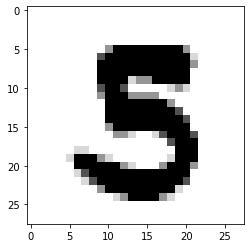

In [14]:
index = 1003
print("Following digit to be recognized:")
show_img(x_test_data_norm,index)

In [15]:
#storing separate models for each percentage(models are indexed with loop counter)

perc=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#perc=[0.4]
coreset_accuracy=[]
label_prediction = []
coreset_model = [0]*len(perc)

print("Begin test: ")
for j in range(len(perc)):
    
    coreset_size=int(perc[j]*len(kl_load_full))
    coreset_data_label=x_data_label_kl_merge_sort[(60000-coreset_size):60000]
    coreset_data=coreset_data_label[:, 0:784]
    coreset_label=coreset_data_label[:,[784]]
    print("Size of Coreset: " +str(len(coreset_data)))
    
    #format conversion
    #convert coreset record to 2D for DL feeding
    coreset_data_2D=[]
    for k in range(len(coreset_data)):
        #coreset_data[k] *= 255
        sqr=np.reshape(coreset_data[k],(28,28))
        coreset_data_2D.append(sqr)

    coreset_data_2D_np=np.array(coreset_data_2D)
    coreset_data_2D_np.shape
    
    #preprocessing for Keras
    coreset_data_2D_train = coreset_data_2D_np.reshape(coreset_data_2D_np.shape[0], 28, 28, 1)
    
    #model initialization
    # Creating a Sequential Model and adding the layers
    input_shape = (28, 28, 1)
    coreset_model[j] = Sequential()
    coreset_model[j].add(Conv2D(28, kernel_size=(4,4), input_shape=input_shape))
    coreset_model[j].add(MaxPooling2D(pool_size=(2, 2)))
    coreset_model[j].add(Flatten()) # Flattening the 2D arrays for fully connected layers
    coreset_model[j].add(Dense(128, activation=tf.nn.relu))
    coreset_model[j].add(Dropout(0.2))
    coreset_model[j].add(Dense(10,activation=tf.nn.softmax))
    
    #model training
    coreset_model[j].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    coreset_model[j].fit(x=coreset_data_2D_train,y=coreset_label, epochs=10)
    
    #model evaluation
    cset_acc=coreset_model[j].evaluate(x_data_2D_test,x_test_label)[1]
    print("\nAccuracy="+str(cset_acc))
    coreset_accuracy.append(cset_acc)
    
    #testing with a test image
    pred = coreset_model[j].predict(x_data_2D_test[index].reshape(1, 28, 28, 1))
    label_prediction.append(pred.argmax())
    print("Test Label: "+str(x_test_label[index]))
    print("Predicted Label: "+str(pred.argmax()))
print("========================")
print("All predictions: ")    
print(label_prediction)    

Begin test: 
Size of Coreset: 6000
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
6000/6000 [==============================] - 1s 202us/sample - loss: 0.4885 - acc: 0.8545
Epoch 2/10
6000/6000 [==============================] - 1s 193us/sample - loss: 0.2154 - acc: 0.9348
Epoch 3/10
6000/6000 [==============================] - 1s 200us/sample - loss: 0.1512 - acc: 0.9542
Epoch 4/10
6000/6000 [==============================] - 1s 197us/sample - loss: 0.0987 - acc: 0.9687
Epoch 5/10
6000/6000 [==============================] - 1s 192us/sample - loss: 0.0755 - acc: 0.9772
Epoch 6/10
6000/6000 [==============================] - 1s 192us/sample - loss: 0.0579 - acc: 0.9817
Epoch 7/10
6000/6000 [==============================] - 1s 194us/sample - loss: 0.0428 - acc: 0.9863
Epoch 8/10
6000/6000 [==============================] - 1s 195us/sample - loss: 0.0368 - acc: 0.9882
Epoch 9/10
6000/6000 [=================

42000/42000 [==============================] - 12s 289us/sample - loss: 0.0398 - acc: 0.9869
Epoch 6/10
42000/42000 [==============================] - 11s 268us/sample - loss: 0.0335 - acc: 0.9883
Epoch 7/10
42000/42000 [==============================] - 11s 270us/sample - loss: 0.0269 - acc: 0.9908
Epoch 8/10
42000/42000 [==============================] - 11s 270us/sample - loss: 0.0263 - acc: 0.9916
Epoch 9/10
42000/42000 [==============================] - 14s 329us/sample - loss: 0.0235 - acc: 0.9922
Epoch 10/10
10000/10000 [==============================] - 1s 112us/sample - loss: 0.0701 - acc: 0.9825

Accuracy=0.9825
Test Label: [5]
Predicted Label: 5
Size of Coreset: 48000
Epoch 1/10
48000/48000 [==============================] - 14s 297us/sample - loss: 0.2156 - acc: 0.9355
Epoch 2/10
48000/48000 [==============================] - 14s 300us/sample - loss: 0.0852 - acc: 0.9746
Epoch 3/10
48000/48000 [==============================] - 14s 297us/sample - loss: 0.0591 - acc: 0.9815


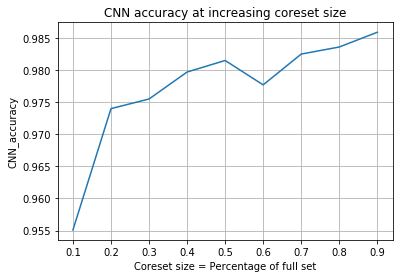

In [20]:
plt.grid(True)
plt.xlabel('Coreset size = Percentage of full set')
plt.ylabel('CNN_accuracy')
plt.title('CNN accuracy at increasing coreset size')
plt.plot(perc,coreset_accuracy)
plt.savefig("Cnn_acc.png")

In [21]:
coreset_accuracy

[0.9551, 0.974, 0.9755, 0.9797, 0.9815, 0.9777, 0.9825, 0.9836, 0.9859]

Following digit to be recognized:


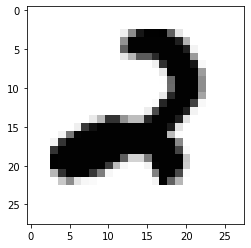

Test Sample No: 7762
Predicted Label with 0.1 ratio having accuracy 0.9551 : 2
Predicted Label with 0.2 ratio having accuracy 0.974 : 2
Predicted Label with 0.3 ratio having accuracy 0.9755 : 2
Predicted Label with 0.4 ratio having accuracy 0.9797 : 2
Predicted Label with 0.5 ratio having accuracy 0.9815 : 2
Predicted Label with 0.6 ratio having accuracy 0.9777 : 2
Predicted Label with 0.7 ratio having accuracy 0.9825 : 2
Predicted Label with 0.8 ratio having accuracy 0.9836 : 2
Predicted Label with 0.9 ratio having accuracy 0.9859 : 2
Test Label: [2]
All predictions: 
[2, 2, 2, 2, 2, 2, 2, 2, 2]
Following digit to be recognized:


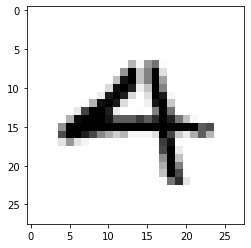

Test Sample No: 4465
Predicted Label with 0.1 ratio having accuracy 0.9551 : 4
Predicted Label with 0.2 ratio having accuracy 0.974 : 4
Predicted Label with 0.3 ratio having accuracy 0.9755 : 4
Predicted Label with 0.4 ratio having accuracy 0.9797 : 4
Predicted Label with 0.5 ratio having accuracy 0.9815 : 4
Predicted Label with 0.6 ratio having accuracy 0.9777 : 4
Predicted Label with 0.7 ratio having accuracy 0.9825 : 4
Predicted Label with 0.8 ratio having accuracy 0.9836 : 4
Predicted Label with 0.9 ratio having accuracy 0.9859 : 4
Test Label: [4]
All predictions: 
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Following digit to be recognized:


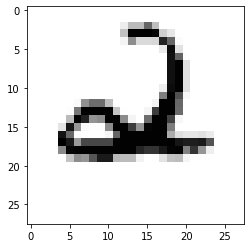

Test Sample No: 1930
Predicted Label with 0.1 ratio having accuracy 0.9551 : 2
Predicted Label with 0.2 ratio having accuracy 0.974 : 2
Predicted Label with 0.3 ratio having accuracy 0.9755 : 2
Predicted Label with 0.4 ratio having accuracy 0.9797 : 4
Predicted Label with 0.5 ratio having accuracy 0.9815 : 2
Predicted Label with 0.6 ratio having accuracy 0.9777 : 2
Predicted Label with 0.7 ratio having accuracy 0.9825 : 2
Predicted Label with 0.8 ratio having accuracy 0.9836 : 2
Predicted Label with 0.9 ratio having accuracy 0.9859 : 2
Test Label: [2]
All predictions: 
[2, 2, 2, 4, 2, 2, 2, 2, 2]
Following digit to be recognized:


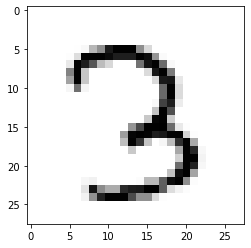

Test Sample No: 142
Predicted Label with 0.1 ratio having accuracy 0.9551 : 3
Predicted Label with 0.2 ratio having accuracy 0.974 : 3
Predicted Label with 0.3 ratio having accuracy 0.9755 : 3
Predicted Label with 0.4 ratio having accuracy 0.9797 : 3
Predicted Label with 0.5 ratio having accuracy 0.9815 : 3
Predicted Label with 0.6 ratio having accuracy 0.9777 : 3
Predicted Label with 0.7 ratio having accuracy 0.9825 : 3
Predicted Label with 0.8 ratio having accuracy 0.9836 : 3
Predicted Label with 0.9 ratio having accuracy 0.9859 : 3
Test Label: [3]
All predictions: 
[3, 3, 3, 3, 3, 3, 3, 3, 3]
Following digit to be recognized:


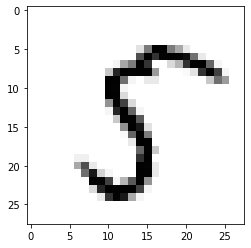

Test Sample No: 4771
Predicted Label with 0.1 ratio having accuracy 0.9551 : 5
Predicted Label with 0.2 ratio having accuracy 0.974 : 5
Predicted Label with 0.3 ratio having accuracy 0.9755 : 5
Predicted Label with 0.4 ratio having accuracy 0.9797 : 5
Predicted Label with 0.5 ratio having accuracy 0.9815 : 5
Predicted Label with 0.6 ratio having accuracy 0.9777 : 5
Predicted Label with 0.7 ratio having accuracy 0.9825 : 5
Predicted Label with 0.8 ratio having accuracy 0.9836 : 5
Predicted Label with 0.9 ratio having accuracy 0.9859 : 5
Test Label: [5]
All predictions: 
[5, 5, 5, 5, 5, 5, 5, 5, 5]
Following digit to be recognized:


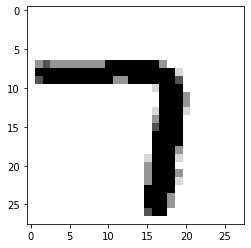

Test Sample No: 4474
Predicted Label with 0.1 ratio having accuracy 0.9551 : 7
Predicted Label with 0.2 ratio having accuracy 0.974 : 7
Predicted Label with 0.3 ratio having accuracy 0.9755 : 7
Predicted Label with 0.4 ratio having accuracy 0.9797 : 7
Predicted Label with 0.5 ratio having accuracy 0.9815 : 7
Predicted Label with 0.6 ratio having accuracy 0.9777 : 7
Predicted Label with 0.7 ratio having accuracy 0.9825 : 7
Predicted Label with 0.8 ratio having accuracy 0.9836 : 7
Predicted Label with 0.9 ratio having accuracy 0.9859 : 7
Test Label: [7]
All predictions: 
[7, 7, 7, 7, 7, 7, 7, 7, 7]
Following digit to be recognized:


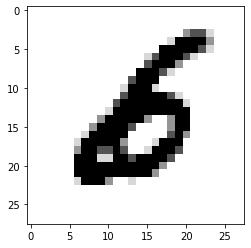

Test Sample No: 3744
Predicted Label with 0.1 ratio having accuracy 0.9551 : 6
Predicted Label with 0.2 ratio having accuracy 0.974 : 6
Predicted Label with 0.3 ratio having accuracy 0.9755 : 6
Predicted Label with 0.4 ratio having accuracy 0.9797 : 6
Predicted Label with 0.5 ratio having accuracy 0.9815 : 6
Predicted Label with 0.6 ratio having accuracy 0.9777 : 6
Predicted Label with 0.7 ratio having accuracy 0.9825 : 6
Predicted Label with 0.8 ratio having accuracy 0.9836 : 6
Predicted Label with 0.9 ratio having accuracy 0.9859 : 6
Test Label: [6]
All predictions: 
[6, 6, 6, 6, 6, 6, 6, 6, 6]
Following digit to be recognized:


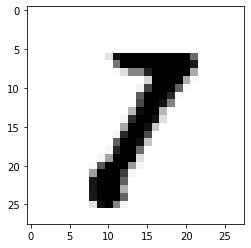

Test Sample No: 4297
Predicted Label with 0.1 ratio having accuracy 0.9551 : 7
Predicted Label with 0.2 ratio having accuracy 0.974 : 7
Predicted Label with 0.3 ratio having accuracy 0.9755 : 7
Predicted Label with 0.4 ratio having accuracy 0.9797 : 7
Predicted Label with 0.5 ratio having accuracy 0.9815 : 7
Predicted Label with 0.6 ratio having accuracy 0.9777 : 1
Predicted Label with 0.7 ratio having accuracy 0.9825 : 7
Predicted Label with 0.8 ratio having accuracy 0.9836 : 7
Predicted Label with 0.9 ratio having accuracy 0.9859 : 7
Test Label: [7]
All predictions: 
[7, 7, 7, 7, 7, 1, 7, 7, 7]
Following digit to be recognized:


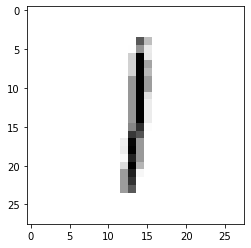

Test Sample No: 176
Predicted Label with 0.1 ratio having accuracy 0.9551 : 1
Predicted Label with 0.2 ratio having accuracy 0.974 : 1
Predicted Label with 0.3 ratio having accuracy 0.9755 : 1
Predicted Label with 0.4 ratio having accuracy 0.9797 : 1
Predicted Label with 0.5 ratio having accuracy 0.9815 : 1
Predicted Label with 0.6 ratio having accuracy 0.9777 : 1
Predicted Label with 0.7 ratio having accuracy 0.9825 : 1
Predicted Label with 0.8 ratio having accuracy 0.9836 : 1
Predicted Label with 0.9 ratio having accuracy 0.9859 : 1
Test Label: [1]
All predictions: 
[1, 1, 1, 1, 1, 1, 1, 1, 1]
Following digit to be recognized:


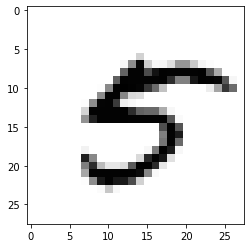

Test Sample No: 3877
Predicted Label with 0.1 ratio having accuracy 0.9551 : 5
Predicted Label with 0.2 ratio having accuracy 0.974 : 5
Predicted Label with 0.3 ratio having accuracy 0.9755 : 5
Predicted Label with 0.4 ratio having accuracy 0.9797 : 5
Predicted Label with 0.5 ratio having accuracy 0.9815 : 5
Predicted Label with 0.6 ratio having accuracy 0.9777 : 5
Predicted Label with 0.7 ratio having accuracy 0.9825 : 5
Predicted Label with 0.8 ratio having accuracy 0.9836 : 5
Predicted Label with 0.9 ratio having accuracy 0.9859 : 5
Test Label: [5]
All predictions: 
[5, 5, 5, 5, 5, 5, 5, 5, 5]


In [22]:
#testing over few images
import random


for i in range(0,10):
    index=random.randint(0,10000)
    print("Following digit to be recognized:")
    show_img(x_test_data_norm,index)
    plt.show()
    print("Test Sample No: "+str(index))
    pred_label = []
    coreset_acc = []
    
    for j in range(len(perc)):
        
        #model evaluation
        #cset_accuracy=coreset_model[j].evaluate(x_data_2D_test,x_test_label)[1]
        #print("\nAccuracy="+str(cset_accuracy))
        #coreset_acc.append(cset_accuracy)
        
        pred = coreset_model[j].predict(x_data_2D_test[index].reshape(1, 28, 28, 1))
        pred_label.append(pred.argmax())
        print("Predicted Label with "+str(perc[j])+" ratio having accuracy "+str(coreset_accuracy[j])+" : "+str(pred.argmax()))
    print("========================")
    print("Test Label: "+str(x_test_label[index]))
    print("All predictions: ")    
    print(pred_label)    
    
        

